In [15]:
kp_cols <- function(...) {
  kp_colors <- c(purple = "#490B32",
                 red = "#9A031E",
                 orange = "#FB8B24",
                 dark_orange = "#E36414",
                 dark_blue = "#0F4C5C",
                 grey = "#66717E",
                 light_green = "#B3CBB9",
                 blue = "#5DA9E9"
  )
  cols <- c(...)
  if (is.null(cols))
    return (kp_colors) 
  kp_colors[cols]
}
kp_pal <- function(palette = "main", reverse = FALSE, ...) {
  kp_palettes <- list(
    "mixed" = kp_cols("purple", "red", "dark_orange", "orange", "dark_blue", "blue", "light_green", "grey")
  )
  pal <- kp_palettes[[palette]]
  if (reverse) pal <- rev(pal)
  colorRampPalette(pal, ...)
}
scale_color <- function(palette = "main", discrete = TRUE, reverse = FALSE, ...) {
  pal <- kp_pal(palette = palette, reverse = reverse) 
  if (discrete) {
    ggplot2::discrete_scale("colour", paste0("kp_", palette), palette = pal, ...)
  } else {
    ggplot2::scale_color_gradientn(colours = pal(256), ...)
  }
}

In [1]:
# Libraries
library(dplyr)
library(ggplot2)
library(tidyr)
library(tidyverse)
library(rpart)
library("rpart.plot")
library(randomForest)
library(xgboost)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
✔ purrr   0.3.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [2]:
songs <- read.csv('dataset/music_genre.csv', stringsAsFactors = FALSE)
head(songs, 10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,32894,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,7.92e-01,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
2,46652,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,9.50e-01,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
3,30097,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,1.18e-02,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
4,62177,Dubloadz,Nitro,34,0.02540,0.774,166875,0.700,2.53e-03,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
5,24907,What So Not,Divide & Conquer,32,0.00465,0.638,222369,0.587,9.09e-01,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
6,89064,Axel Boman,Hello,47,0.00523,0.755,519468,0.731,8.54e-01,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.614,Electronic
7,43760,Jordan Comolli,Clash,46,0.02890,0.572,214408,0.803,7.74e-06,B,0.1060,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic
8,30738,Hraach,Delirio,43,0.02970,0.809,416132,0.706,9.03e-01,G,0.0635,-9.339,Minor,0.0484,120.008,4-Apr,0.761,Electronic
9,84950,Kayzo,NEVER ALONE,39,0.00299,0.509,292800,0.921,2.76e-04,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,4-Apr,0.273,Electronic


In [3]:
glimpse(songs)

Rows: 50,005
Columns: 18
$ instance_id      <dbl> 32894, 46652, 30097, 62177, 24907, 89064, 43760, 3073…
$ artist_name      <chr> "Röyksopp", "Thievery Corporation", "Dillon Francis",…
$ track_name       <chr> "Röyksopp's Night Out", "The Shining Path", "Hurrican…
$ popularity       <dbl> 27, 31, 28, 34, 32, 47, 46, 43, 39, 22, 30, 27, 31, 3…
$ acousticness     <dbl> 4.68e-03, 1.27e-02, 3.06e-03, 2.54e-02, 4.65e-03, 5.2…
$ danceability     <dbl> 0.652, 0.622, 0.620, 0.774, 0.638, 0.755, 0.572, 0.80…
$ duration_ms      <dbl> -1, 218293, 215613, 166875, 222369, 519468, 214408, 4…
$ energy           <dbl> 0.941, 0.890, 0.755, 0.700, 0.587, 0.731, 0.803, 0.70…
$ instrumentalness <dbl> 7.92e-01, 9.50e-01, 1.18e-02, 2.53e-03, 9.09e-01, 8.5…
$ key              <chr> "A#", "D", "G#", "C#", "F#", "D", "B", "G", "F", "A",…
$ liveness         <dbl> 0.1150, 0.1240, 0.5340, 0.1570, 0.1570, 0.2160, 0.106…
$ loudness         <dbl> -5.201, -7.043, -4.617, -4.498, -6.266, -10.517, -4.2…
$ mode         

In [4]:
songs <- na.omit(songs)

In [5]:
songs$tempo <- as.numeric(songs$tempo)
songs$popularity <- as.numeric(songs$popularity)
songs$mode <- as.numeric(gsub("Minor", 1, gsub("Major", 0, songs$mode)))
songs$key <- as.numeric(factor(songs$key))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [6]:
songs <- na.omit(songs)

In [7]:
songs$tempo <- as.numeric(songs$tempo)
songs$popularity <- as.numeric(songs$popularity)
songs$mode <- as.numeric(gsub("Minor", 1, gsub("Major", 0, songs$mode)))
songs$key <- as.numeric(factor(songs$key))

In [8]:
songs %>% 
  count(music_genre) %>%
  knitr::kable()



|music_genre |    n|
|:-----------|----:|
|Alternative | 4495|
|Anime       | 4497|
|Blues       | 4470|
|Classical   | 4500|
|Country     | 4486|
|Electronic  | 4466|
|Hip-Hop     | 4520|
|Jazz        | 4521|
|Rap         | 4504|
|Rock        | 4561|

In [9]:
write.csv(songs,"processed_songs.csv", row.names = FALSE)

In [13]:
chisq.test(songs$music_genre, songs$acousticness, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$acousticness
X-squared = 66823, df = NA, p-value = 0.0004998


In [14]:
chisq.test(songs$music_genre, songs$danceability, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$danceability
X-squared = 33232, df = NA, p-value = 0.0004998


In [15]:
chisq.test(songs$music_genre, songs$instance_id)

Warning message in chisq.test(songs$music_genre, songs$instance_id):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  songs$music_genre and songs$instance_id
X-squared = 405180, df = 405171, p-value = 0.4957


In [16]:
chisq.test(songs$music_genre, songs$popularity, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$popularity
X-squared = 59507, df = NA, p-value = 0.0004998


In [17]:
chisq.test(songs$music_genre, songs$duration_ms, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$duration_ms
X-squared = 220989, df = NA, p-value = 0.0004998


In [18]:
chisq.test(songs$music_genre, songs$energy, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$energy
X-squared = 42737, df = NA, p-value = 0.0004998


In [19]:
chisq.test(songs$music_genre, songs$instrumentalness, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$instrumentalness
X-squared = 68203, df = NA, p-value = 0.0004998


In [20]:
chisq.test(songs$music_genre, songs$key, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$key
X-squared = 2195.1, df = NA, p-value = 0.0004998


In [21]:
chisq.test(songs$music_genre, songs$liveness, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$liveness
X-squared = 16417, df = NA, p-value = 0.0004998


In [22]:
chisq.test(songs$music_genre, songs$loudness, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$loudness
X-squared = 156216, df = NA, p-value = 0.0004998


In [23]:
chisq.test(songs$music_genre, songs$speechiness, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  songs$music_genre and songs$speechiness
X-squared = 30829, df = NA, p-value = 0.0004998


In [24]:
summary(songs)

  instance_id    artist_name         track_name          popularity   
 Min.   :20002   Length:45020       Length:45020       Min.   : 0.00  
 1st Qu.:38001   Class :character   Class :character   1st Qu.:34.00  
 Median :55858   Mode  :character   Mode  :character   Median :45.00  
 Mean   :55885                                         Mean   :44.26  
 3rd Qu.:73856                                         3rd Qu.:56.00  
 Max.   :91759                                         Max.   :99.00  
  acousticness     danceability     duration_ms          energy        
 Min.   :0.0000   Min.   :0.0596   Min.   :     -1   Min.   :0.000792  
 1st Qu.:0.0201   1st Qu.:0.4420   1st Qu.: 174723   1st Qu.:0.432000  
 Median :0.1450   Median :0.5680   Median : 219438   Median :0.642000  
 Mean   :0.3066   Mean   :0.5585   Mean   : 221169   Mean   :0.599553  
 3rd Qu.:0.5510   3rd Qu.:0.6870   3rd Qu.: 268640   3rd Qu.:0.815250  
 Max.   :0.9960   Max.   :0.9860   Max.   :4497994   Max.   :0.999000  

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(feats)

  # Now:
  data %>% select(all_of(feats))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



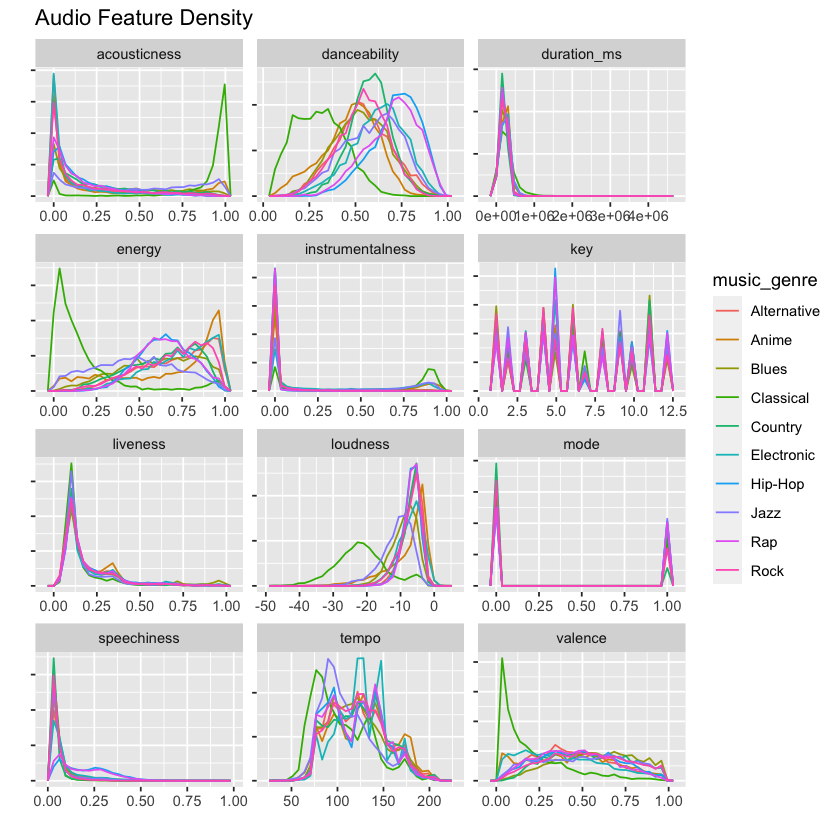

In [10]:
feats <- names(songs)[c(5:15,17)]

img_songs <- songs %>%
  select(c('music_genre', feats)) %>%
  pivot_longer(cols = feats) 

img_songs %>%
  ggplot(aes(x = value)) + geom_freqpoly(aes(color = music_genre)) + facet_wrap(~name, ncol = 3, scales = 'free') + 
  labs(title = 'Audio Feature Density', x = '', y = '') + theme(axis.text.y = element_blank())

In [11]:
songs$popularity<-ifelse(songs$popularity>55,1,0)

`summarise()` has grouped output by 'music_genre'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'music_genre'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'music_genre'. You can override using the
`.groups` argument.


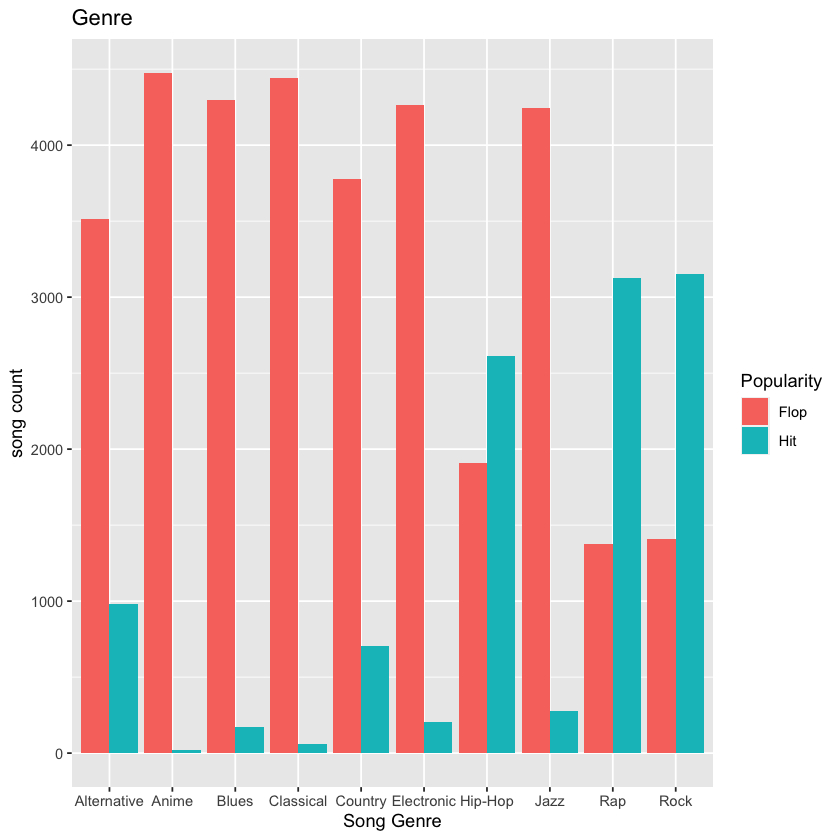

In [12]:
music_tibble <- as_tibble(songs)

genre_count_df <- music_tibble %>%
group_by(music_genre, popularity) %>% 
  summarise(counts = n()) 

genre_hit_count_total <- genre_count_df %>% 
group_by(music_genre, popularity) %>% 
  summarise(counts = sum(counts)) 

genre_hit_count_total %>%  
group_by(music_genre, popularity) %>%  
summarize(counts = sum(counts)) %>%  
  ggplot(aes(x=music_genre, y=counts, fill=as.factor(popularity)))+
  geom_bar(stat="identity", position="dodge")+labs(title="Genre", x="Song Genre", y="song count")+
  scale_fill_discrete(name = "Popularity", labels = c("Flop", "Hit")) 

`summarise()` has grouped output by 'music_genre', 'popularity'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'music_genre', 'popularity'. You can
override using the `.groups` argument.


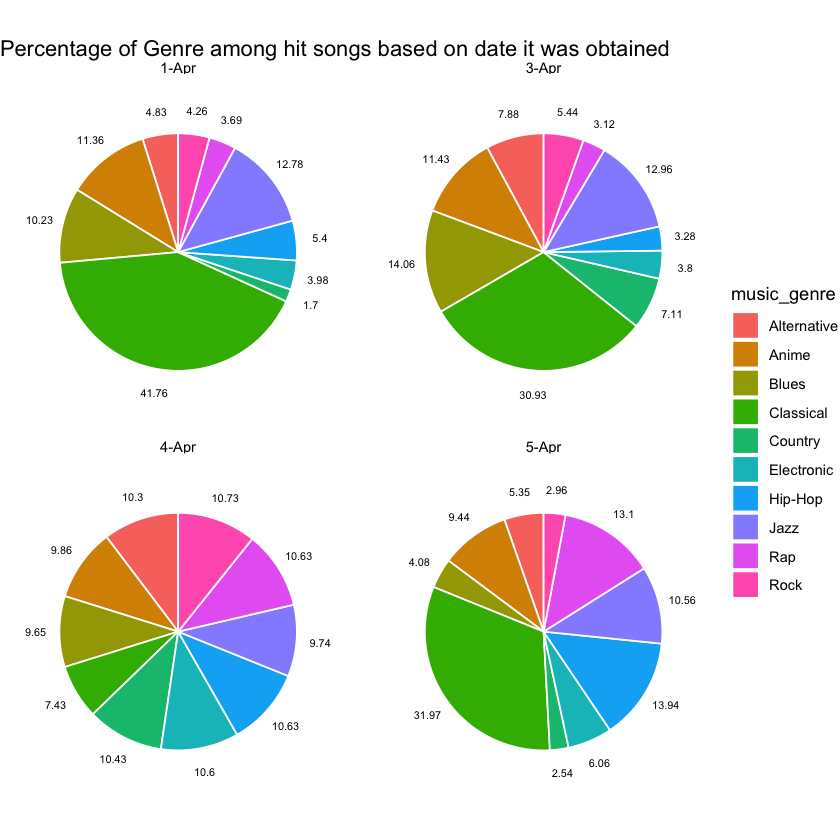

In [16]:
genre_hit <- music_tibble %>%
group_by(music_genre, popularity, obtained_date) %>% 
  summarise(counts = n()) 

date_list<-c("1April", "3April", "4April", "5April")

genre_hit_dates <- genre_hit %>% 
group_by(music_genre, popularity=1, obtained_date) %>% 
  summarise(counts = sum(counts)) 

genre_hit_dates <- genre_hit_dates %>% 
group_by(obtained_date) %>%  
  mutate(percent =as.numeric(format(round(100*(counts/sum(counts)), 2), nsmall = 2)))  

ggplot(transform(genre_hit_dates, 
date=factor(obtained_date,levels=date_list)), aes(x = "", y = percent, fill = music_genre)) + 
  geom_bar(width = 1, stat = "identity", color = "white") + 
  coord_polar("y", start = 0)+ 
  theme_void() +  
  labs(title="Percentage of Genre among hit songs based on date it was obtained") + 
  facet_wrap( ~ obtained_date) + 
  geom_text(aes(x=1.7,label = percent), size=2.3, position = position_stack(vjust = 0.5)) + 
  scale_color(palette = 'mixed')

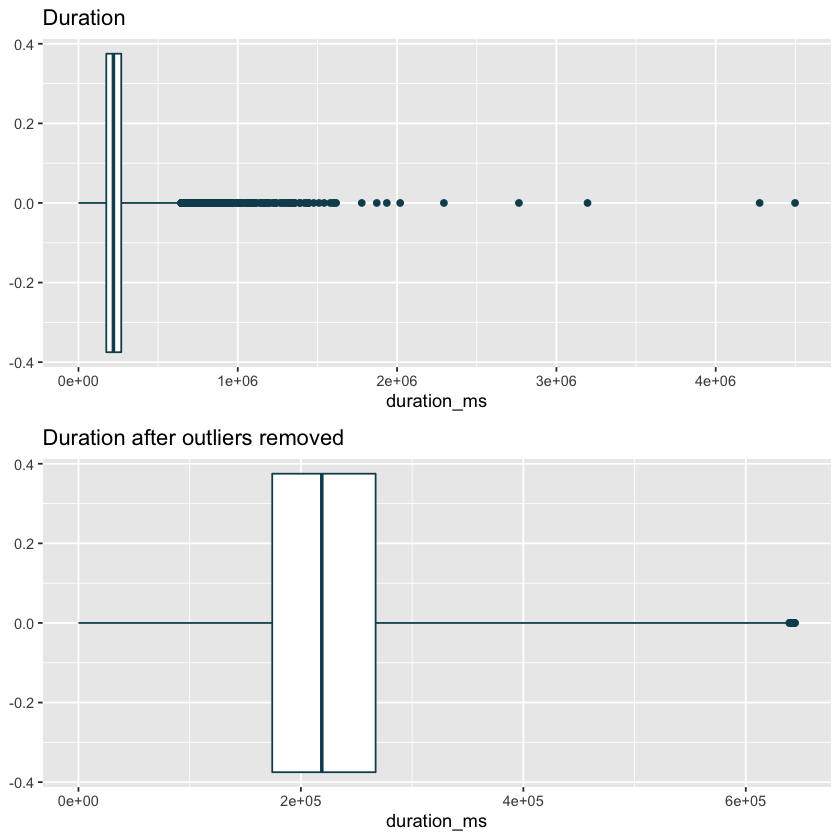

In [17]:
songs_out <- songs %>%
  ggplot(aes(y = duration_ms)) + geom_boxplot(color = kp_cols('dark_blue'), coef = 4) +
  coord_flip() + labs(title = 'Duration') 

duration_out <- boxplot(songs$duration_ms, plot = FALSE, range = 4)$out

songs_wo_out <- songs %>%
  filter(!duration_ms %in% duration_out) 

wo_out <- songs_wo_out %>%
  ggplot(aes(y = duration_ms)) + geom_boxplot(color = kp_cols('dark_blue'), coef = 4) +
  coord_flip() + labs(title = 'Duration after outliers removed') 

gridExtra::grid.arrange(songs_out, wo_out, ncol = 1)

In [30]:
summary(songs_wo_out)

  instance_id    artist_name         track_name          popularity    
 Min.   :20005   Length:44662       Length:44662       Min.   :0.0000  
 1st Qu.:38016   Class :character   Class :character   1st Qu.:0.0000  
 Median :55872   Mode  :character   Mode  :character   Median :0.0000  
 Mean   :55901                                         Mean   :0.2531  
 3rd Qu.:73878                                         3rd Qu.:1.0000  
 Max.   :91759                                         Max.   :1.0000  
  acousticness     danceability     duration_ms         energy        
 Min.   :0.0000   Min.   :0.0596   Min.   :    -1   Min.   :0.000792  
 1st Qu.:0.0198   1st Qu.:0.4450   1st Qu.:174227   1st Qu.:0.437000  
 Median :0.1420   Median :0.5700   Median :218806   Median :0.645000  
 Mean   :0.3032   Mean   :0.5607   Mean   :215588   Mean   :0.602221  
 3rd Qu.:0.5410   3rd Qu.:0.6887   3rd Qu.:267171   3rd Qu.:0.817000  
 Max.   :0.9960   Max.   :0.9860   Max.   :644273   Max.   :0.999000  

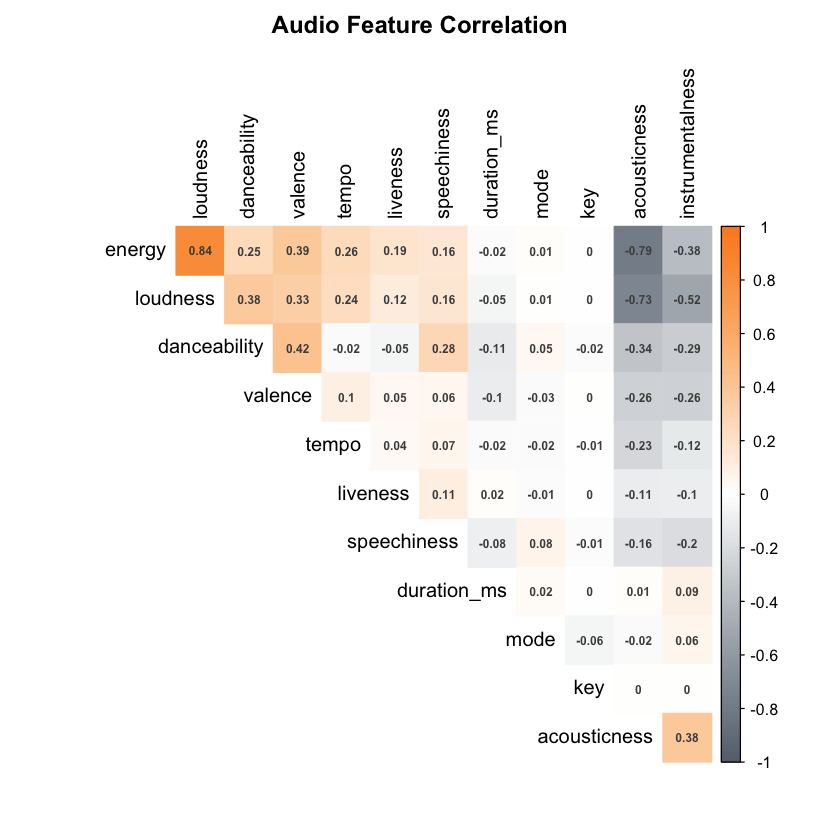

In [18]:
songs_wo_out %>%
  select(feats) %>%
  scale() %>%
  cor() %>%
    corrplot::corrplot(method = 'color', order = 'hclust', type = 'upper', diag = FALSE, tl.col = 'black', 
    addCoef.col = "grey30", number.cex = 0.6, col = colorRampPalette(colors = c(kp_cols('grey'), 'white', 
    kp_cols('orange')))(200), main = 'Audio Feature Correlation', mar = c(2,2,2,2))

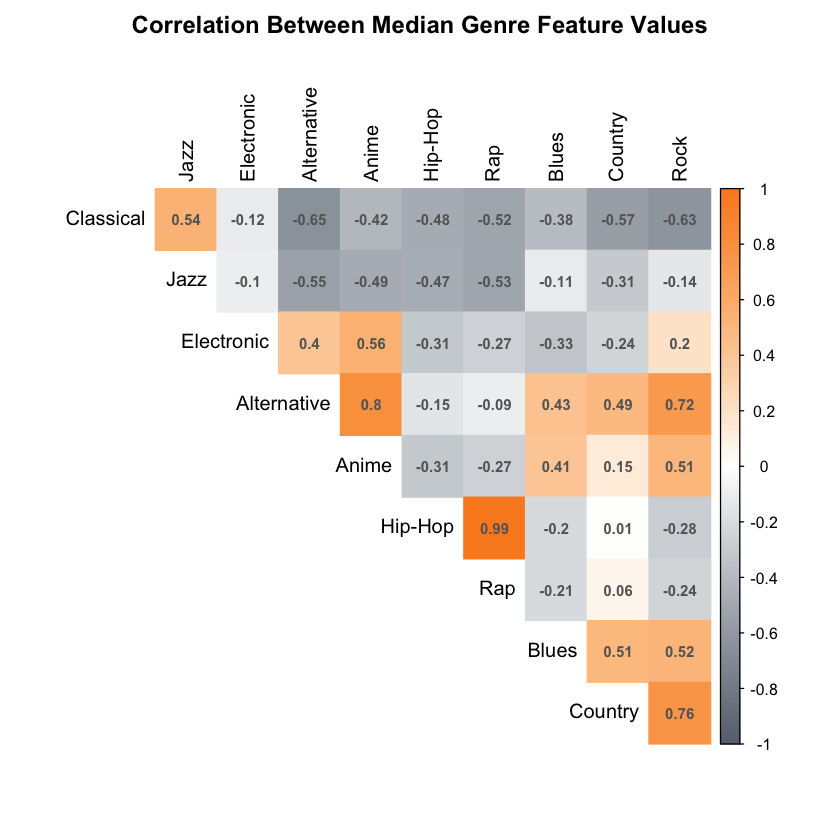

In [19]:
avg_genre_matrix <- songs_wo_out %>%
  group_by(music_genre) %>%
  summarise_if(is.numeric, median, na.rm = TRUE) %>%
  ungroup() 

avg_genre_cor <- avg_genre_matrix %>%
  select(feats, -mode) %>% 
  scale() %>%
  t() %>%
  as.matrix() %>%
  cor() 

colnames(avg_genre_cor) <- avg_genre_matrix$music_genre
row.names(avg_genre_cor) <- avg_genre_matrix$music_genre

avg_genre_cor %>% corrplot::corrplot(method = 'color', order = 'hclust', type = 'upper', tl.col = 'black', 
                                     diag = FALSE, addCoef.col = "grey40", number.cex = 0.75, 
                                     col = colorRampPalette(colors = c( kp_cols('grey'), 'white',  
                                                                       kp_cols('orange')))(200),
                                     mar = c(2,2,2,2),main = 'Correlation Between Median Genre Feature Values')

In [22]:
write.csv(songs_wo_out,"processed_songs.csv", row.names = FALSE)

In [20]:
feats <- names(songs)[c(5:11,13:15,17)]

In [21]:
train_songs <- songs_wo_out %>%
  mutate_if(is.numeric, scale)

training_songs <- sample(1:nrow(train_songs), nrow(train_songs)*.75, replace = FALSE)
train_set <- train_songs[training_songs, c('music_genre', feats)] 
test_set <- train_songs[-training_songs, c('music_genre', feats)] 

train_resp <- train_songs[training_songs, 'music_genre']
test_resp <- train_songs[-training_songs, 'music_genre']

In [20]:
decision_tree <- rpart(music_genre ~ ., data = train_set)

predict_dt <- predict(object = decision_tree, newdata = test_set)
max_id <- apply(predict_dt, 1, which.max)
pred <- levels(as.factor(test_set$music_genre))[max_id]

compare_dt <- data.frame(true_value = test_set$music_genre, predicted_value = pred, model = 'decision_tree',
                         stringsAsFactors = FALSE)

model_accuracy_calc <- function(df, model_name) {
  df %>% 
    mutate(match = ifelse(true_value == predicted_value, TRUE, FALSE)) %>% 
    count(match) %>% 
    mutate(accuracy = n/sum(n),model = model_name)
}

accuracy_dt <- model_accuracy_calc(df = compare_dt, model_name = 'decision_tree')
accuracy_dt

match,n,accuracy,model
<lgl>,<int>,<dbl>,<chr>
FALSE,7463,0.6683683,decision_tree
TRUE,3703,0.3316317,decision_tree


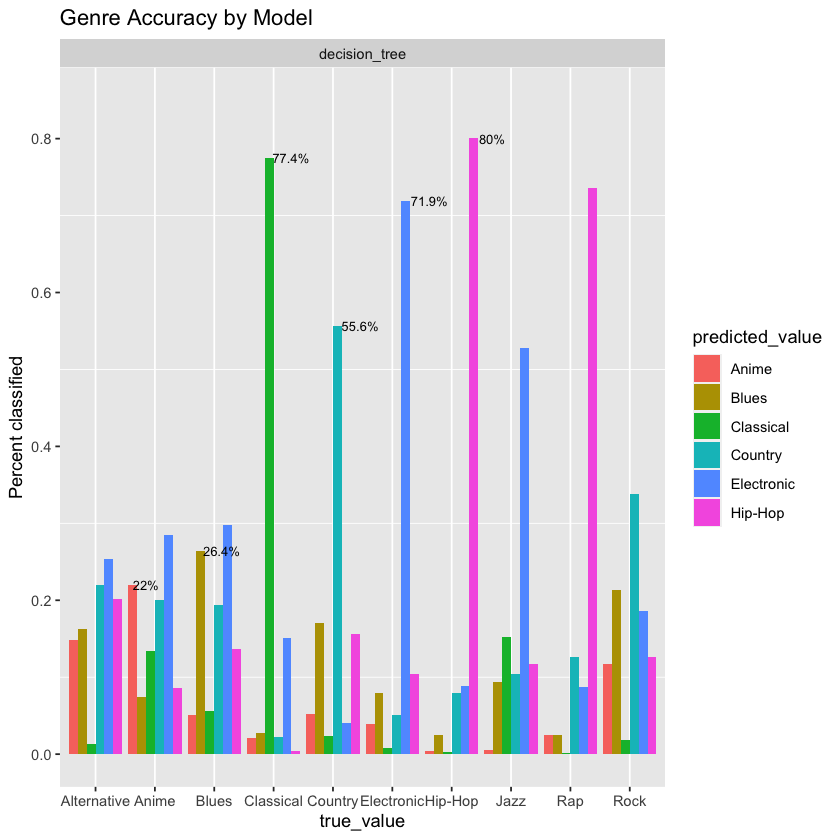

In [21]:
compare_dt %>%
  count(true_value, predicted_value, model) %>%
  mutate(match = ifelse(true_value == predicted_value, TRUE, FALSE)) %>%
  group_by(true_value, model) %>%
  mutate(pct = n/sum(n)) %>% 
  ungroup() %>%
  mutate(label = ifelse(match == TRUE, 
                        paste0(round(pct * 100,1),'%'), 
                        "")) %>%
  ggplot(aes(x = true_value, 
             y = pct, 
             fill = predicted_value, 
             label = label)) + geom_col(position = 'dodge') + geom_text(position = position_dodge(width = 1), 
                                                                        cex = 2.75, 
                                                                        hjust = -0.1) +
  facet_wrap( ~ model, ncol = 3) + 
  labs(title = 'Genre Accuracy by Model',y = 'Percent classified') + ylim(c(0,.85)) + 
  theme(panel.grid.major.y = element_blank()) + scale_color(palette = 'mixed')

In [22]:
model_rf <- randomForest(as.factor(music_genre) ~ ., ntree = 100, importance = TRUE, data = train_set)

predict_rf <- predict(model_rf, test_set)

compare_rf <- data.frame(true_value = test_resp,
                         predicted_value = predict_rf,
                         model = 'random_forest',
                         stringsAsFactors = FALSE) 

accuracy_rf <- model_accuracy_calc(df = compare_rf, model_name = 'random_forest')
accuracy_rf


match,n,accuracy,model
<lgl>,<int>,<dbl>,<chr>
FALSE,6475,0.5798854,random_forest
TRUE,4691,0.4201146,random_forest


In [23]:
knitr::kable(model_rf$confusion)



|            | Alternative| Anime| Blues| Classical| Country| Electronic| Hip-Hop| Jazz|  Rap| Rock| class.error|
|:-----------|-----------:|-----:|-----:|---------:|-------:|----------:|-------:|----:|----:|----:|-----------:|
|Alternative |         628|   356|   267|        14|     347|        296|     332|  196|  333|  626|   0.8150221|
|Anime       |         318|  1528|   177|       375|     253|        216|      39|  199|   19|  222|   0.5433353|
|Blues       |         261|   210|  1176|        53|     392|        163|      86|  520|   59|  390|   0.6447130|
|Classical   |          87|   166|    52|      2638|      12|         44|       0|  165|    2|   28|   0.1740764|
|Country     |         180|   136|   318|        10|    1791|         30|     129|  129|  145|  469|   0.4632904|
|Electronic  |         204|   182|   145|        19|      71|       1984|     150|  364|   98|  143|   0.4095238|
|Hip-Hop     |         177|    31|    54|         2|      64|        126|    1230|   6

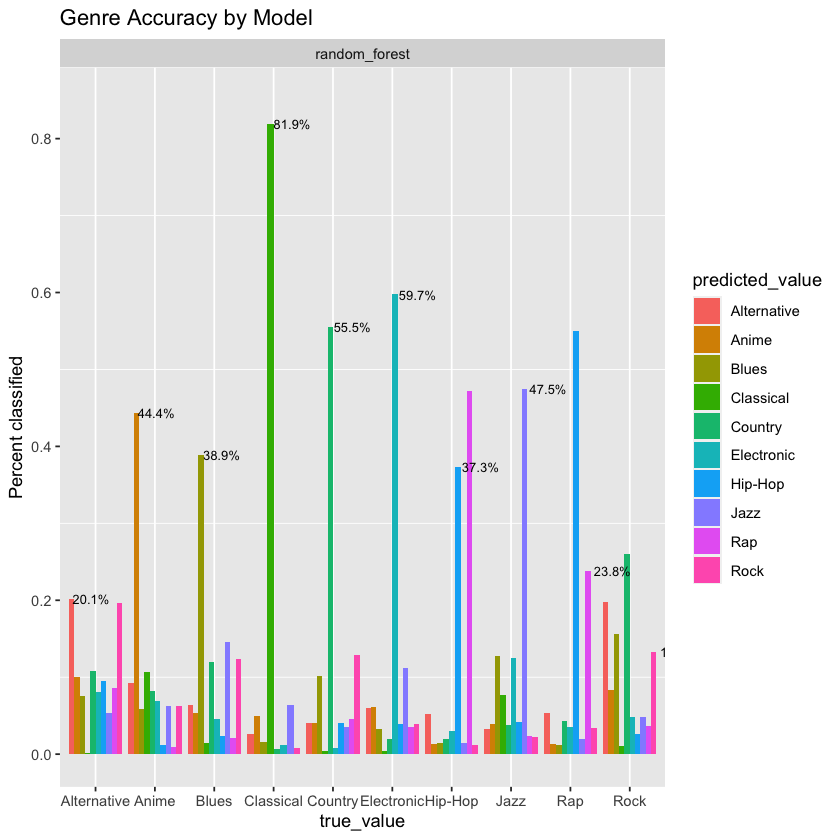

In [24]:
compare_rf %>%
  count(true_value, predicted_value, model) %>%
  mutate(match = ifelse(true_value == predicted_value, TRUE, FALSE)) %>%
  group_by(true_value, model) %>%
  mutate(pct = n/sum(n)) %>% 
  ungroup() %>%
  mutate(label = ifelse(match == TRUE, 
                        paste0(round(pct * 100,1),'%'), 
                        "")) %>%
  ggplot(aes(x = true_value, 
             y = pct, 
             fill = predicted_value, 
             label = label)) + geom_col(position = 'dodge') + geom_text(position = position_dodge(width = 1), 
                                                                        cex = 2.75, 
                                                                        hjust = -0.1) +
  facet_wrap( ~ model, ncol = 3) + 
  labs(title = 'Genre Accuracy by Model',y = 'Percent classified') + ylim(c(0,.85)) + 
  theme(panel.grid.major.y = element_blank()) + scale_color(palette = 'mixed')

In [25]:

matrix_train_gb <- xgb.DMatrix(data = as.matrix(train_set[,-1]), label = as.integer(as.factor(train_set[,1])))
matrix_test_gb <- xgb.DMatrix(data = as.matrix(test_set[,-1]), label = as.integer(as.factor(test_set[,1])))

model_gb <- xgboost(data = matrix_train_gb, 
                    nrounds = 50,
                    verbose = FALSE,
                    params = list(objective = "multi:softmax",
                                  num_class = 10 + 1))

predict_gb <- predict(model_gb, matrix_test_gb)
predict_gb <- levels(as.factor(test_set$music_genre))[predict_gb]

compare_gb <- data.frame(true_value = test_resp,
                         predicted_value = predict_gb,
                         model = 'xgboost',
                         stringsAsFactors = FALSE) 

accuracy_gb <- model_accuracy_calc(df = compare_gb, model_name = 'xgboost')
accuracy_gb

match,n,accuracy,model
<lgl>,<int>,<dbl>,<chr>
FALSE,6142,0.5500627,xgboost
TRUE,5024,0.4499373,xgboost


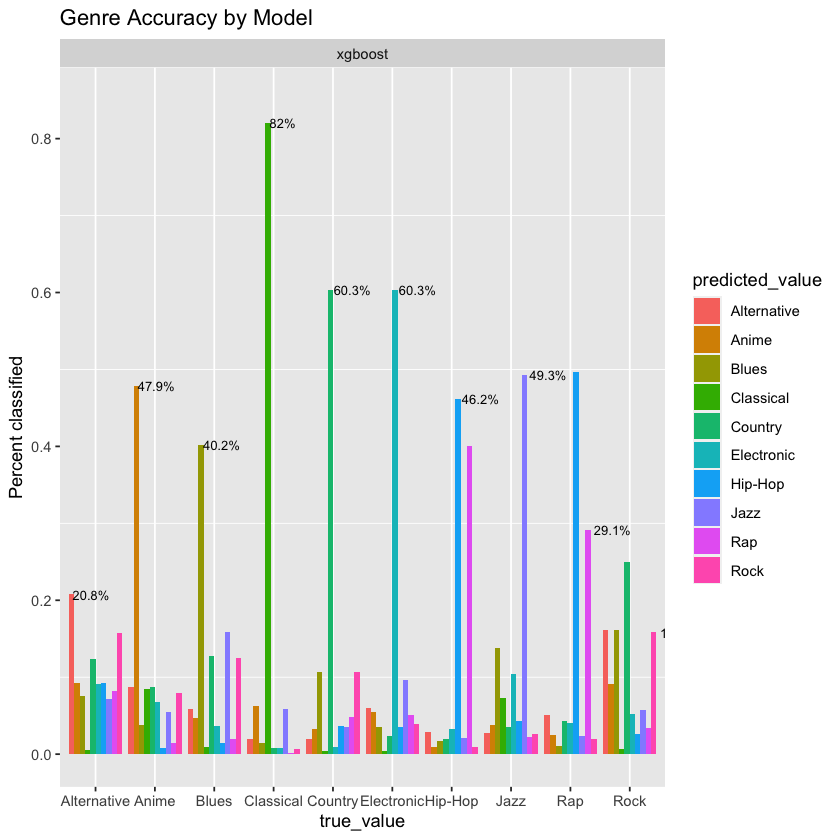

In [26]:
compare_gb %>%
  count(true_value, predicted_value, model) %>%
  mutate(match = ifelse(true_value == predicted_value, TRUE, FALSE)) %>%
  group_by(true_value, model) %>%
  mutate(pct = n/sum(n)) %>% 
  ungroup() %>%
  mutate(label = ifelse(match == TRUE, 
                        paste0(round(pct * 100,1),'%'), 
                        "")) %>%
  ggplot(aes(x = true_value, 
             y = pct, 
             fill = predicted_value, 
             label = label)) + geom_col(position = 'dodge') + geom_text(position = position_dodge(width = 1), 
                                                                        cex = 2.75, 
                                                                        hjust = -0.1) +
  facet_wrap( ~ model, ncol = 3) + 
  labs(title = 'Genre Accuracy by Model',y = 'Percent classified') + ylim(c(0,.85)) + 
  theme(panel.grid.major.y = element_blank()) + scale_color(palette = 'mixed')

Warning message:
“Removed 2 rows containing missing values (geom_point).”


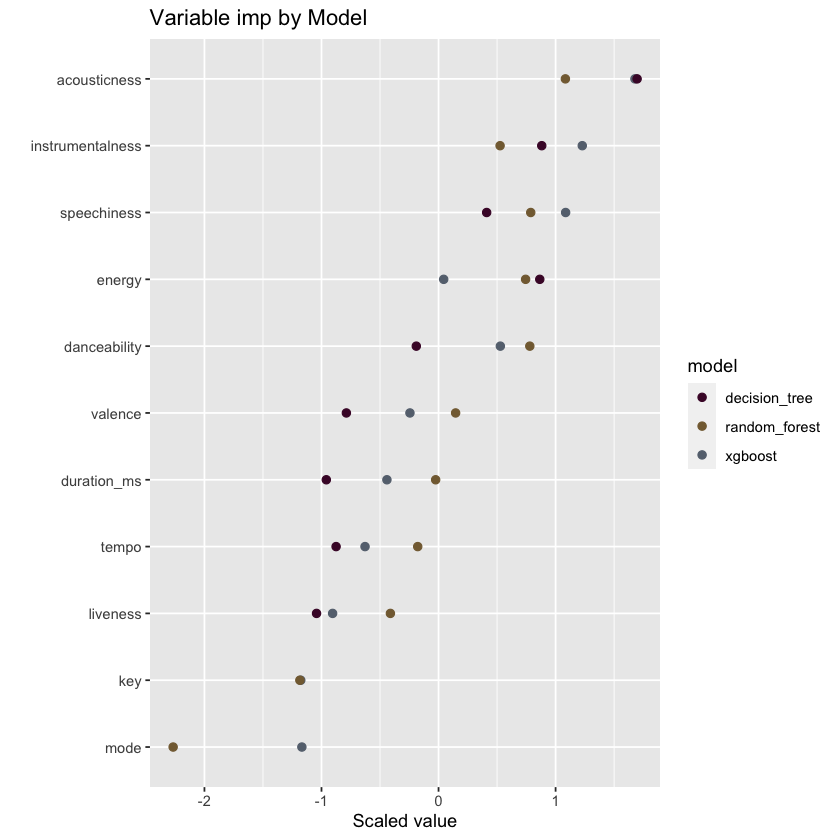

In [28]:
imp_dt <- data.frame(importance = decision_tree$variable.importance)
imp_dt$feature <- row.names(imp_dt)

imp_rf <- data.frame(importance = importance(model_rf, type = 2))
imp_rf$feature <- row.names(imp_rf)

imp_gb <- xgb.importance(model = model_gb)

comp_imp <- imp_gb %>%
  select(Feature, Gain) %>%
  left_join(imp_dt, by = c('Feature' = 'feature')) %>%
  left_join(imp_rf, by = c('Feature' = 'feature')) %>%
  rename('xgboost' = 'Gain',
         'decision_tree' = 'importance',
         'random_forest' = 'MeanDecreaseGini') 

comp_imp %>%
  mutate_if(is.numeric, scale, center = TRUE) %>%
  pivot_longer(cols = c('xgboost', 'decision_tree', 'random_forest')) %>%
  rename('model' = 'name') %>%
  ggplot(aes(x = reorder(Feature, value, mean, na.rm = TRUE), y = value, color = model)) + geom_point(size = 2) + 
  coord_flip() + labs(title = 'Variable imp by Model',
                      y = 'Scaled value', x = '') + scale_color(palette = 'mixed')